### Automated ML

This script setups and executes an Azure AutoML pipeline to let AzureML intelligently find the best regression algorithm and hyperparameter combination to predict the mortgage rate in a pre-engineered dataset we provided it.

To do so we already provisioned the data in form of an AzureML dataset named **EngineeredMortgageSpread** using the script ProvisionDataSets.py to make it available for the training cluster. All we still need to do then is to define the target column, rescrictions in form of time limits, the primary metrics and the amount of compute power we want to provide and then AutoML basically executes the complete training process for us.

After the process has finished it tells us the best run and it's metrics so we could right afterwards forward it e.g. for regression tests.

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [116]:
import logging
import os
import sys
import csv
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import pkg_resources
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.pipeline.steps import AutoMLStep
from azureml.pipeline.core import Pipeline
from azureml.pipeline.core import PipelineData, TrainingOutput
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.webservice import AciWebservice
# Check core SDK version number
print("SDK version:", azureml.core.VERSION)
# add common directory as module search path
common_path = os.getcwd()+"/../common"
if not common_path in sys.path:
    sys.path.append(common_path)
%load_ext autoreload
%autoreload 2
from ml_principal_authenticate import AzureMLAuthenticator
from notebook_check import *
from seaborn_vis import *

SDK version: 1.19.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# configuration
experiment_timeout = 120 # Best result achieved after 65 minutes

main_test_set = "EngineeredMortgageSpread"
unclean_test_set = "UncleanedMortgageSpread"
import argparse
if check_isnotebook(): # calm down argparse when testing in a notebook
    sys.argv = ['']
parser = argparse.ArgumentParser()
parser.add_argument('--unclean', type=bool, default=False, help="Defines if the uncleaned, unengineered data set shall be used")
args = parser.parse_args()
if args.unclean:
    used_data_set = unclean_test_set
else:
    used_data_set = main_test_set
print(f"Using dataset {used_data_set}...")

Using dataset EngineeredMortgageSpread...


### Log into AzureML Workspace

In [3]:
print("Connecting to AzureML Workspace...")
config_path = os.path.normpath(f"{os.getcwd()}/../Config")
service_authenticator = AzureMLAuthenticator(config_path=config_path)

ws = service_authenticator.get_workspace("aml_research")
if ws is not None:
    print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')
else:
    print("Workspace not available")

Connecting to AzureML Workspace...
aml_research
aml_research
westeurope
3cd9cbbe-bebe-4315-a11d-47eed87a8547


### Set up training cluster

In [4]:
print("Setting up compute cluster...")

amlcompute_cluster_name = "tmplpriocluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    compute_target.update(min_nodes=5, max_nodes=5, idle_seconds_before_scaledown=600)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',# for GPU, use "STANDARD_NC6"
                                                           vm_priority = 'lowpriority',
                                                           min_nodes=5,
                                                           max_nodes=5)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True, min_node_count = 5, timeout_in_minutes = 10)

Setting up compute cluster...
Creating
Succeeded.....................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Dataset

### Overview

I am using the mortgage loan rate spread data set which was till 2019 used in Microsoft's Data Science Professional program. The goal of this project was to especially analyze the rate spread in the US between different groups of people such as male and female, ethical and religous groups to verify that there is **no discrimation** involved in the computation of the effective loan rate they were given. The dataset contains real information about Americans and the **rate_spread** to the current base interest rate defined at that point of time in state which is our target label in the experiments.

A very detailed overview of the data you can find here:
https://github.com/Alyxion/MPPDataScience/blob/master/MPP_DS_FinalReport.pdf

I chose this dataset because it it's especially "dirty", this means that it contains large amounts of categorical data, missing values, outliers etc.. You can find the original data here:
https://github.com/Alyxion/Udacity_AzureMLEngineer/tree/main/Project_03_Capstone/data

As the original data is basically not usable by a classic algorithm I already curated it in the original project which you can find here:

In this project both, the Azure ML as the HyperDrive approach, both use the curated data I named "engineered". This data has already been stored in the Azure ML Datasets using the **ProvisionDataSets.py** script you can find in this notebook's directory.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [21]:
dataset = None
if used_data_set in ws.datasets.keys(): 
    print("Dataset found, downloading it...")
    dataset = ws.datasets[used_data_set]
df = dataset.to_pandas_dataframe()
visualize_nb_data(df.describe())

Dataset found, downloading it...


,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,lender_spread_lt,lender_spread_lp,lender_spread_pt,county_spread,loantype_aspread,proptype_aspread,loanpurp_aspread,occupancy_aspread,state_spread,income_loan_rel
count,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,...,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00,200000.00
mean,99999.50,1.57,1.15,1.48,1.06,142.57,2.70,226.97,28.20,166.34,...,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.86
std,57735.17,0.56,0.37,0.82,0.25,142.56,0.55,106.66,15.59,92.85,...,1.36,1.37,1.36,0.58,0.69,0.86,0.31,0.04,0.35,1.64
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,-1.00,0.00,...,-0.97,-0.97,-0.97,-0.97,-0.85,-0.36,-0.13,-0.01,-0.63,0.00
25%,49999.75,1.00,1.00,1.00,1.00,67.00,2.00,154.00,14.00,83.00,...,-0.81,-0.80,-0.79,-0.40,-0.62,-0.36,-0.06,-0.01,-0.27,0.33
50%,99999.50,2.00,1.00,1.00,1.00,116.00,3.00,261.00,30.00,181.00,...,-0.65,-0.65,-0.62,-0.18,-0.62,-0.36,-0.06,-0.01,-0.09,0.49
75%,149999.25,2.00,1.00,2.00,1.00,179.00,3.00,318.00,41.00,249.00,...,0.21,0.10,0.08,0.22,0.75,-0.36,-0.06,-0.01,0.13,0.86
max,199999.00,4.00,3.00,3.00,3.00,11104.00,3.00,408.00,52.00,316.00,...,6.03,6.03,6.03,6.03,0.75,2.01,1.28,0.41,1.04,270.55


In [6]:
visualize_nb_data(dataset.take(5).to_pandas_dataframe())

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,lender_spread_lt,lender_spread_lp,lender_spread_pt,county_spread,loantype_aspread,proptype_aspread,loanpurp_aspread,occupancy_aspread,state_spread,income_loan_rel
0,0,2,1,1,1,139.0,1,261,14,246,...,-0.742752,-0.708915,-0.689624,0.217119,-0.620380,-0.364393,-0.061103,-0.00892,0.250070,0.553957
1,1,2,2,1,1,160.0,3,349,48,311,...,-0.494021,-0.428029,-0.502672,0.564956,-0.620380,2.011958,-0.061103,-0.00892,0.133498,0.262500
2,2,1,2,1,1,168.0,3,385,30,256,...,3.721786,3.717423,3.721861,-0.534250,0.752205,2.011958,-0.061103,-0.00892,-0.127125,0.202381
3,3,1,2,1,1,57.0,3,117,30,46,...,3.721786,3.717423,3.721861,-0.040448,0.752205,2.011958,-0.061103,-0.00892,-0.127125,0.649123
4,4,2,1,2,1,25.0,3,95,41,192,...,1.275630,1.641015,1.425630,-0.406509,-0.620380,-0.364393,1.280664,-0.00892,-0.260579,1.840000


### Setup experiment

In [7]:
experiment_name = 'AzureMLCapstoneExperiment'
if args.unclean:
    experiment_name = 'AzureMLCapstoneExperimentUnclean'
project_folder = './pipeline-project'
experiment = Experiment(ws, experiment_name)
if check_isnotebook():
    display(experiment)

Name,Workspace,Report Page,Docs Page
AzureMLCapstoneExperiment,aml_research,Link to Azure Machine Learning studio,Link to Documentation


### AutoML configuration

TODO: Explain why you chose the automl settings and configuration you used below.

The data we want to predict is the **rate_spread**, so basically the offset to the base interest rate in the US at this point of time. As the **rate_spread** is a continuous value our task is a **regression task**. As primary metric I chose the r2_score - the reason for this is that this was also the goal of a contest related to Microsoft's MPP project in the past on the one hand and I wanted a comparable result as outcome. Independent of this the r2 score is very well suited to regression tasks which large data variance such as ours. Further details you can find here: https://en.wikipedia.org/wiki/Coefficient_of_determination

As our datasets has more than 70 columns and more than 100,000 lines of data and the problem itself is quite difficult I had to choose a quite large timeout of 120 minutes. Depending on the vm size it also needs at least 70 minutes to find the best algorithm. To minimize the waiting time and to use maximum use of the up to 20 low priority vCPUs cores available in an MSDN subscription I defined a maximum of 5 concurrent iterations.

In [8]:
automl_settings = {
    "experiment_timeout_minutes": experiment_timeout,
    "max_concurrent_iterations": 5,
    "primary_metric" : 'r2_score'
}
automl_config = AutoMLConfig(compute_target=compute_target,
                             task = "regression",
                             training_data=dataset,
                             label_column_name="rate_spread",   
                             path = project_folder,
                             enable_early_stopping= True,                             
                             featurization= 'auto',
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )
ds = ws.get_default_datastore()
metrics_output_name = 'metrics_output'
best_model_output_name = 'best_model_output'

metrics_data = PipelineData(name='metrics_data',
                           datastore=ds,
                           pipeline_output_name=metrics_output_name,
                           training_output=TrainingOutput(type='Metrics'))
model_data = PipelineData(name='model_data',
                           datastore=ds,
                           pipeline_output_name=best_model_output_name,
                           training_output=TrainingOutput(type='Model'))
automl_step = AutoMLStep(
    name='automl_module',
    automl_config=automl_config,
    outputs=[metrics_data, model_data],
    allow_reuse=True)
pipeline = Pipeline(
    description="pipeline_with_automlstep",
    workspace=ws,    
    steps=[automl_step])

### Execute pipeline and wait for it to finish

In [9]:
pipeline_run = experiment.submit(pipeline)

Created step automl_module [77ec0404][b4a4b543-8859-47ad-8762-a2318be27ca7], (This step will run and generate new outputs)
Submitted PipelineRun 7954f504-dc2b-4409-a7ad-3537ddf841a2
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/AzureMLCapstoneExperiment/runs/7954f504-dc2b-4409-a7ad-3537ddf841a2?wsid=/subscriptions/3cd9cbbe-bebe-4315-a11d-47eed87a8547/resourcegroups/aml_research/workspaces/aml_research


### Run Details

TODO: In the cell below, use the RunDetails widget to show the different experiments.

In [10]:
if check_isnotebook():
    from azureml.widgets import RunDetails
    RunDetails(pipeline_run).show()

_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

### Clean up computing resources and test the model

In [11]:
print("Waiting for ML run to finish execution...")
pipeline_run.wait_for_completion()
print("Deleting computing resources...")
compute_target.delete()

Waiting for ML run to finish execution...
PipelineRunId: 7954f504-dc2b-4409-a7ad-3537ddf841a2
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/AzureMLCapstoneExperiment/runs/7954f504-dc2b-4409-a7ad-3537ddf841a2?wsid=/subscriptions/3cd9cbbe-bebe-4315-a11d-47eed87a8547/resourcegroups/aml_research/workspaces/aml_research
PipelineRun Status: Running


StepRunId: fc685780-71ca-43f0-b972-4ea87fbde2bf
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/AzureMLCapstoneExperiment/runs/fc685780-71ca-43f0-b972-4ea87fbde2bf?wsid=/subscriptions/3cd9cbbe-bebe-4315-a11d-47eed87a8547/resourcegroups/aml_research/workspaces/aml_research
StepRun( automl_module ) Status: NotStarted
StepRun( automl_module ) Status: Running

StepRun(automl_module) Execution Summary
StepRun( automl_module ) Status: Finished
{'runId': 'fc685780-71ca-43f0-b972-4ea87fbde2bf', 'target': 'tmplpriocluster', 'status': 'Completed', 'startTimeUtc': '2021-02-01T10:08:29.914853Z', 'endTimeUtc'

In [12]:
metrics_output = pipeline_run.get_pipeline_output(metrics_output_name)
num_file_downloaded = metrics_output.download('.', show_progress=True)

Downloaded azureml/fc685780-71ca-43f0-b972-4ea87fbde2bf/metrics_data, 1 files out of an estimated total of 1


In [22]:
import json
with open(metrics_output._path_on_datastore) as f:
    metrics_output_result = f.read()
    
deserialized_metrics_output = json.loads(metrics_output_result)
metrics = pd.DataFrame(deserialized_metrics_output)
visualize_nb_data(metrics)

,fc685780-71ca-43f0-b972-4ea87fbde2bf_16,fc685780-71ca-43f0-b972-4ea87fbde2bf_18,fc685780-71ca-43f0-b972-4ea87fbde2bf_21,fc685780-71ca-43f0-b972-4ea87fbde2bf_6,fc685780-71ca-43f0-b972-4ea87fbde2bf_0,fc685780-71ca-43f0-b972-4ea87fbde2bf_5,fc685780-71ca-43f0-b972-4ea87fbde2bf_35,fc685780-71ca-43f0-b972-4ea87fbde2bf_27,fc685780-71ca-43f0-b972-4ea87fbde2bf_28,fc685780-71ca-43f0-b972-4ea87fbde2bf_33,...,fc685780-71ca-43f0-b972-4ea87fbde2bf_10,fc685780-71ca-43f0-b972-4ea87fbde2bf_2,fc685780-71ca-43f0-b972-4ea87fbde2bf_26,fc685780-71ca-43f0-b972-4ea87fbde2bf_37,fc685780-71ca-43f0-b972-4ea87fbde2bf_3,fc685780-71ca-43f0-b972-4ea87fbde2bf_23,fc685780-71ca-43f0-b972-4ea87fbde2bf_39,fc685780-71ca-43f0-b972-4ea87fbde2bf_24,fc685780-71ca-43f0-b972-4ea87fbde2bf_22,fc685780-71ca-43f0-b972-4ea87fbde2bf_31
normalized_mean_absolute_error,[0.07312091213480418],[0.07114330174207616],[0.07286063599401803],[0.07143655520286381],[0.06568681224708972],[0.07240140481980535],[0.06827964735925197],[0.07113316588470196],[0.07224744738159708],[0.08161567046628962],...,[0.07363055419106976],[0.07281585523166827],[0.07109204290899153],[0.06956641512309691],[0.0706499026159061],[0.0664196949928518],[0.06494667230782192],[0.06866377821564675],[0.0695837490075756],[0.08208322379577963]
explained_variance,[0.754847305041117],[0.7725875879030923],[0.7562003677997142],[0.7753307751708167],[0.8144663731298577],[0.7588238945252339],[0.800405709679329],[0.7713923231971951],[0.7629958250994469],[0.7307669319313359],...,[0.7737955471063579],[0.7800467200577874],[0.7714501533187627],[0.7821334771852956],[0.7836096595729476],[0.8094147718013782],[0.8172152087354378],[0.8006282165603767],[0.7958992033215122],[0.7305789410637089]
normalized_median_absolute_error,[0.0419752326087122],[0.04022276334805487],[0.04157595045914778],[0.04015357601354579],[0.03847162509281737],[0.041116519316837984],[0.036238746983664374],[0.041769738338532626],[0.04261985695520284],[0.04589924034937468],...,[0.04329680467643498],[0.038144128663199287],[0.041726748493665235],[0.0402744630071599],[0.04122020991215277],[0.039736482231971806],[0.03861485778359849],[0.0407482555934361],[0.041582338834344354],[0.04842998085910059]
normalized_root_mean_squared_error,[0.11286436793784341],[0.10870320880680649],[0.11255259745160069],[0.10804420732456632],[0.09818548984987453],[0.11194552345924688],[0.10184805732542138],[0.10898832200377458],[0.11099397987919273],[0.11827466059918304],...,[0.10841382370596345],[0.1069037288497137],[0.10897461796469736],[0.10639737984750064],[0.10603569683986572],[0.09951232430581047],[0.09745324677829206],[0.10178012887848285],[0.10298023461719483],[0.1183170901369595]
r2_score,[0.7548322329198456],[0.7725769956378755],[0.7561848387756962],[0.7753260921345926],[0.8144571230074471],[0.7588078732707866],[0.8003565054113714],[0.7713824341277585],[0.7628907416232873],[0.7307640276984292],...,[0.7737862557453369],[0.7800442235860269],[0.7714399226188251],[0.7821229279864248],[0.7836016955253854],[0.809408554282185],[0.8172142691392392],[0.800622724530593],[0.7958932262884268],[0.7305708230537813]
spearman_correlation,[0.7085723846077636],[0.7240354193933155],[0.7098586004911391],[0.723438112027191],[0.7371293202157747],[0.7125629282476644],[0.722934055444222],[0.7184656057406551],[0.7114837280178434],[0.6634187927707815],...,[0.7162910889660216],[0.6980680142284593],[0.7188285316973709],[0.7261132462367341],[0.7255413563777566],[0.7332145074129687],[0.7398491613238405],[0.7255914411355493],[0.7216376181511535],[0.6633450785911456]
root_mean_squared_log_error,[0.21620524585022244],[0.21077967270632883],[0.21554636161642995],[0.21090354898109592],[0.19580247600686876],[0.21438345874987896],[0.20063905365995668],[NaN],[NaN],[0.22899902821999402],...,[0.21138945513636506],[NaN],[NaN],[0.20793610526073736],[0.20760940087541743],[0.19830166590541054],[0.19455408485367431],[0.2020394295634449],[0.20446737365852016],[0.2292649163354665]
root_mean_squared_error,[0.7900505755649039],[0.7

### Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.

In [14]:
# Retrieve best model from Pipeline Run
best_model_output = pipeline_run.get_pipeline_output(best_model_output_name)
num_file_downloaded = best_model_output.download('.', show_progress=True)

Downloaded azureml/fc685780-71ca-43f0-b972-4ea87fbde2bf/model_data, 1 files out of an estimated total of 1


In [ ]:
best_model

In [50]:
import pickle

with open(best_model_output._path_on_datastore, "rb" ) as f:
    best_model = pickle.load(f)
visualize_nb_data(best_model)

RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                             logger=None,
                                                             observer=None,
                                         

In [16]:
visualize_nb_data(best_model.steps)

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('4',
                                            Pipeline(memory=None,
                                                     steps=[('standardscalerwrapper',
                                                             <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f436d0ce1d0>),
                                                            ('xgboostregressor',
                                                             XGBoostRegressor(base_score=0.5,
                                                        

200000
Selecting sample
Done
Executing prediction
Predictions:
[4.53094664 2.09234321 1.18976192 2.54846644 2.76056722 1.27535623
 4.83814081 2.40164711 3.37532249 1.17338202 1.55309167 5.35194678
 1.51162765 1.16621007 3.31340732 1.05770622 3.51976791 1.55390382
 1.56898475 1.160617   1.50380733 6.91198523 4.03405079 1.239523
 2.67278893 1.84410418 1.13415435 6.7947731  1.17786271 1.20593834
 1.16349232 1.46431589 1.17975    1.07033259 1.09438928 3.38578676
 5.46492306 1.11944164 6.06515428 1.97862904 1.03988791 1.16856462
 1.80693321 1.48734922 1.03079969 1.35527317 1.16389016 1.19037129
 1.75688806 1.18703825]
Real values:
[6.0, 1.0, 2.0, 3.0, 3.0, 2.0, 5.0, 2.0, 3.0, 1.0, 2.0, 8.0, 2.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 7.0, 4.0, 1.0, 3.0, 2.0, 1.0, 8.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 3.0, 6.0, 1.0, 7.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0]


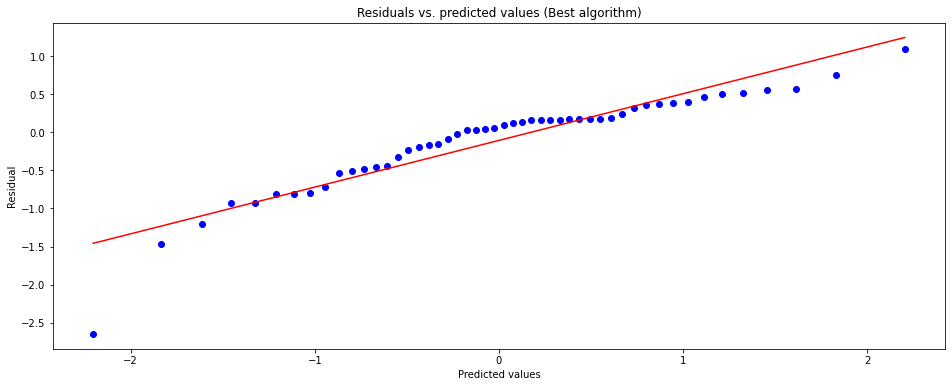

In [83]:
print(len(df))
print("Selecting sample")
df_test = df.sample(50)
print("Done")
y_test = df_test['rate_spread']
df_test = df_test.drop(['rate_spread'], axis=1)
X_test = df_test
print("Executing prediction")
y_pred = best_model.predict(X_test)
print("Predictions:")
print(y_pred)
print("Real values:")
print(y_test.tolist())
if seaborn_available:
    resid_qq(y_pred, np.array(y_test.tolist()), 'Best algorithm')

In [176]:
import shutil
try:
    os.mkdir("temp")
except:
    pass
try:
    os.mkdir("temp/outputs")
except:
    pass
df_test.to_json("temp/test_sample.json")
shutil.copy(best_model_output._path_on_datastore, "temp/model_data")

'temp/model_data'

### Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [55]:
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration
import sklearn

model = Model.register(workspace=ws,
                      model_name='mortgage_rate_automl_model',                # Name of the registered model in your workspace.
                      model_path=best_model_output._path_on_datastore)        # Local file to upload and register as a model.

Registering model mortgage_rate_automl_model


### Configure Python environment with all modules required to execute AutoML pickles

In [114]:
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment

# Create the environment
myenv = Environment(name="mortgage_score_env")
conda_dep = CondaDependencies()

# Define the packages needed by the model and scripts
conda_dep.add_conda_package("numpy")
conda_dep.add_conda_package("pip")
conda_dep.add_conda_package("scikit-learn=0.22.2.post1")
# You must list azureml-defaults as a pip dependency
conda_dep.add_pip_package("azureml-defaults==1.11.0")
conda_dep.add_pip_package("azureml-core")
conda_dep.add_pip_package("azureml-automl-runtime")
conda_dep.add_pip_package("packaging")
conda_dep.add_pip_package("azureml-explain-model==1.11.0")
conda_dep.add_pip_package("inference-schema")
conda_dep.add_conda_package("numpy")
# scikit-learn>=0.19.0,<=0.20.3
conda_dep.add_conda_package("pandas")
conda_dep.add_conda_package("py-xgboost")
# Save environment also locally to disk so we can test the score script directly by creating a local environment
conda_dep.save('temp/mortgage_score_env.yml')
myenv.python.conda_dependencies = conda_dep

### Setup web service and inference configuration

We are deploying the local script score.py as entry point and the environment defined above. Also we enabled authentication, even if our deployment is just for a short while.

In [250]:
webservice_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, auth_enabled=True)
inference_config = InferenceConfig(entry_script='score.py', environment=myenv)

### Test in local docker container

For faster pre-evaluation (as a web deployment can take up to 10 minutes) I test the script locally (which usually just takes 20 seconds) before deploying it to the web.

In [246]:
print("\nTesting inference using local docker container before deploying it as web service\n")
from azureml.core.webservice import LocalWebservice
# This is optional, if not provided Docker will choose a random unused port.
deployment_config = LocalWebservice.deploy_configuration(port=6789)
local_service = Model.deploy(ws, "local-mortgage-service-test", [model], inference_config, deployment_config)
local_service.wait_for_deployment()
single_row_data = df_test[0:10].to_json()
run_data = json.dumps({'data':single_row_data})
result = local_service.run(run_data)
print("Inference result")
print(result)
print("Success" if len(result)==10 else "Failed")
local_service.delete()

Testing inference using local docker container before deploying it as web service
Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 6411698d86a44b828bf0a5312cd3fdca.azurecr.io
Logging into Docker registry 6411698d86a44b828bf0a5312cd3fdca.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 6411698d86a44b828bf0a5312cd3fdca.azurecr.io/azureml/azureml_560c94dc160e355b5067ad799e0933a0
 ---> f4984579f9b0
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> a77f72485141
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6IjNjZDljYmJlLWJlYmUtNDMxNS1hMTFkLTQ3ZWVkODdhODU0NyIsInJlc291cmNlR3JvdXBOYW1lIjoiYW1sX3Jlc2VhcmNoIiwiYWNjb3VudE5hbWUiOiJhbWxfcmVzZWFyY2giLCJ3b3Jrc3BhY2VJZCI6IjY0MTE2OThkLTg2YTQtNGI4Mi04YmYwLWE1MzEyY2QzZmRjYSJ9LCJtb2RlbHMiOnt9LCJtb2RlbHNJbmZvIjp7fX0= | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 3a4ba55dd4df
 ---> b581712a3ddd
Step 4/5 : RUN mv '/var

In [251]:
print("Deploying web inference service...")
web_service = model.deploy(workspace=ws, name="mortgage-service", models=[model], inference_config=inference_config,
    deployment_config=webservice_config, overwrite=True)
web_service.wait_for_deployment(show_output=True)
web_service.update(enable_app_insights=True)

Deploying web inference service...
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...........................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


TODO: In the cell below, send a request to the web service you deployed to test it.

In [255]:
print("\n\nTesting web service via WebService class interface...")
result = web_service.run(run_data)
print("Inference result")
print(result)
print("Success" if len(result)==10 else "Failed")



Testing web service via WebService class interface...
Inference result
[4.530946639603756, 2.0923432062516287, 1.1897619172986387, 2.548466442611093, 2.7605672168760793, 1.2753562271238341, 4.8381408086369095, 2.401647110588428, 3.375322488111953, 1.1733820249508218]
Success


In [256]:
import requests
scoring_uri = web_service.scoring_uri
print(f"\n\nTesting web service directly via requests module. Calling URL {scoring_uri}...")
primary_key = web_service.get_keys()[0]
# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {primary_key}'
result = json.loads(requests.post(scoring_uri, headers=headers, data=run_data).text)
print("Inference result")
print(result)
print("Success" if len(result)==10 else "Failed")



Testing web service directly via requests module. Calling URL http://d9e67cb1-2734-4194-801c-05a3ae2dbb4b.westeurope.azurecontainer.io/score...
Inference result
[4.530946639603756, 2.0923432062516287, 1.1897619172986387, 2.548466442611093, 2.7605672168760793, 1.2753562271238341, 4.8381408086369095, 2.401647110588428, 3.375322488111953, 1.1733820249508218]
Success


TODO: In the cell below, print the logs of the web service and delete the service

In [257]:
import time
logs = web_service.get_logs()
print(logs)
time.sleep(120.0)  # wait a moment - otherwise we will receive an error as the deployment isn't yet finished 100%
print("Cleaning up and deleting web service...")
web_service.delete()
print("Done")

2021-02-01T16:51:20,032874800+00:00 - iot-server/run 
2021-02-01T16:51:20,031769000+00:00 - gunicorn/run 
2021-02-01T16:51:20,059320700+00:00 - rsyslog/run 
2021-02-01T16:51:20,102618200+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_205138a6f62584a8f814f8e4b01b27ce/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_205138a6f62584a8f814f8e4b01b27ce/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_205138a6f62584a8f814f8e4b01b27ce/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_205138a6f62584a8f814f8e4b01b27ce/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_205138a6f62584a8f814f8e4b01b27ce/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
EdgeHubC

Cleaning up and deleting web service...
Done
